In [81]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


# Load The dataset
file_path = '/content/10Benzema20Neymar26RonaldoUPDATED1.csv'
data = pd.read_csv(file_path, low_memory=False)

# Specify the tokenized text column in your DataFrame
text = 'preprocessed_text_tokenized'

# Function to calculate polarity
def get_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply the sentiment analysis function to the 'text_data' column and create a new 'polarity' column
data['polarity'] = data[text].apply(get_polarity)


# Assign labels based on polarity
data['polarity_label'] = data['polarity'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

data['polarity_label'] = data['polarity_label'].map({'negative': -1,'neutral': 0, 'positive': 1})
data

,preprocessed_text_tokenized,polarity,polarity_label
0,"['yet', 'benzema', 'co', 'dy', 'stink', 'saudi...",0.800000,1
1,"['talk', 'ronaldo', 'top', 'player', 'saudi', ...",0.500000,1
2,"['speak', 'reality', 'penaldo', 'delude', 'hat...",-0.400000,-1
3,"['obviously', 'know', 'ligue', 'one', 'player'...",0.000000,0
4,"['forgotten', 'benzema', 'firminho', 'mahrez',...",0.000000,0
...,...,...,...
52387,"['break', 'prick', 'sha', 'yes', 'knew', 'saud...",0.000000,0
52388,"['jealous', 'usa', 'treat', 'messi', 'like', '...",0.000000,0
52389,"['messi', 'v', 'ronaldo', 'never', 'gonna', 'g...",-0.025000,-1
52390,"['yes', 'happen', 'bcoz', 'right', 'even', 'kn...",0.285714,1


In [68]:
# Import the TfidfVectorizer class from scikit-learn and initialize it
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
# Transform the preprocessed and tokenized text data into TF-IDF matrix.
X = tfidf.fit_transform(data['preprocessed_text_tokenized'])
# Extract the target labels from the DataFrame, which represent the sentiment polarity.
y = data['polarity_label']

In [69]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Import the LightGBM library
import lightgbm as lgb

# Initialize the LightGBM classifier
clf = lgb.LGBMClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.626079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90826
[LightGBM] [Info] Number of data points in the train set: 41913, number of used features: 2134
[LightGBM] [Info] Start training from score -1.743893
[LightGBM] [Info] Start training from score -1.046049
[LightGBM] [Info] Start training from score -0.746888


LGBMClassifier()

In [71]:
# Predict the results using the trained classifier
y_pred = clf.predict(X_test)

In [72]:
# Importing the accuracy_score function from the scikit-learn library
from sklearn.metrics import accuracy_score

# Calculating the accuracy score
accuracy = accuracy_score(y_pred, y_test)

# Create a DataFrame with Text, Actual_Labels, and Predicted_Labels columns
result_df = pd.DataFrame({
    'Text': X_test,
    'Actual_Labels': y_test,
    'Predicted_Labels': y_pred
})

# Save the DataFrame to a CSV file
result_df.to_csv("/content/test_predictionsLGBM.csv", index=False)


# Displaying the accuracy score
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))


LightGBM Model accuracy score: 0.8881


In [73]:
#Compare train and test set accuracy
y_pred_train = clf.predict(X_train)

In [74]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9059


**Check for Overfitting**

In [75]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9059
Test set score: 0.8881


**Confusion-matrix**


In [76]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1425  193  156]
 [  24 3532   34]
 [ 169  597 4349]]

True Positives(TP) =  1425

True Negatives(TN) =  3532

False Positives(FP) =  193

False Negatives(FN) =  24


<Axes: >

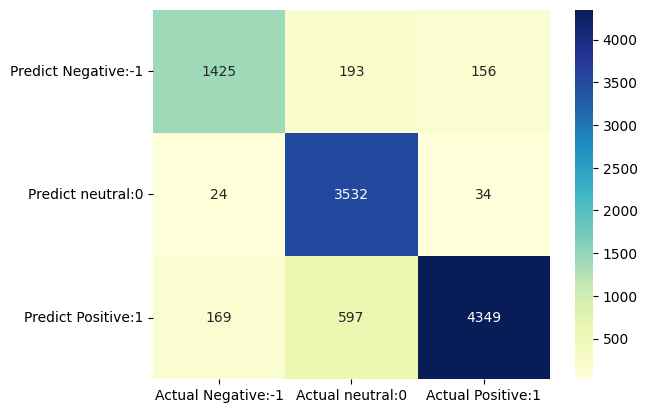

In [77]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:-1', 'Actual neutral:0', 'Actual Positive:1'],
                                 index=['Predict Negative:-1', 'Predict neutral:0', 'Predict Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

**Classification Metrices**


In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.88      0.80      0.84      1774
           0       0.82      0.98      0.89      3590
           1       0.96      0.85      0.90      5115

    accuracy                           0.89     10479
   macro avg       0.89      0.88      0.88     10479
weighted avg       0.90      0.89      0.89     10479



In [79]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score on the test set
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Weighted Precision on Test Set: {precision:.4f}')
print(f'Weighted Recall on Test Set: {recall:.4f}')
print(f'Weighted F1-score on Test Set: {f1:.4f}')


Weighted Precision on Test Set: 0.8968
Weighted Recall on Test Set: 0.8881
Weighted F1-score on Test Set: 0.8879


In [80]:
from sklearn.metrics import roc_auc_score

# Predict the probabilities for each class
y_pred_prob = clf.predict_proba(X_test)

# Compute OvR ROC AUC
roc_auc_ovr = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
print('OvR ROC AUC Score: {0:0.4f}'.format(roc_auc_ovr))

OvR ROC AUC Score: 0.9598
